In [1]:
import sys
sys.path.append('../../')
sys.path.append('../')

dataset_path = "../dataset"
preprocessed_dataset_path = "../dataset/preprocessed_dataset"

from codes.docs.analysis import data_preprocessing, genetic_file_preprocess
from codes.docs.analysis.nimagen import genes, stats, visualisation

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.io
import glob
from collections import defaultdict
%matplotlib inline

In [2]:
european_volumetric_dataset_term = pd.read_csv('../dataset/preprocessed_dataset/imaging_data/log_file/rel3/volumetric/european_volumetric_df_rel3_batch2.csv')

In [3]:
european_volumetric_dataset_term = european_volumetric_dataset_term[(european_volumetric_dataset_term['radiology_score']<5)&(european_volumetric_dataset_term['radiology_low_image_quality']==False)]

`european_volumetric_dataset_term` has 279 observations (after removal of low image quality and radiology score)

In [4]:
# tract_volumes = pd.read_csv('../codes/FBA/output/aba/wm_parcellation_volume.txt',delim_whitespace=True,header=None)
# tract_volumes = tract_volumes.iloc[:,np.r_[[0]+[i for i in range(94,148)]]]
tract_volumes = pd.read_csv('../codes/FBA/output_ASD/aba/mean_log_jacob.txt',delim_whitespace=True,header=None)

In [5]:
tract_volumes.columns = ['ID/Ses']+[f'wm_{i}' for i in range(94,148)]
tract_volumes = tract_volumes.drop_duplicates('ID/Ses')

In [6]:
available_dwi = pd.read_csv('../codes/FBA/subject_lists/available_dwi.txt',header=None,names=['ID','Session'])
available_dwi['ID/Ses'] = available_dwi['ID']+'/'+available_dwi['Session'].astype('str')

In [7]:
df = european_volumetric_dataset_term.copy()

ancestry = [f'euro_Anc_PC{i}'
            for i in range(1, 4)]  # remove any ancestry outliers

df = stats.MassUnivariate.remove_outliers(
    df,
    col=ancestry,
    threshold=3.5,
    remove_schemes='any',
    percentage_of_outlier=0.1)

df = df.drop(columns='ASD_PRS_Pt_1e-07')

pca, prs_pca, loading_matrix = stats.FeatureReduction.perform_PCA(
    df,
    dependentVar_cols=[i for i in df.columns if 'ASD_PRS' in i],
    scaling=True,
    n_components=1
)

df['ASD_PRS_PC1'] = prs_pca

In [8]:
df['ID/Ses'] = 'sub-'+df['ID']+'/ses-'+df['Session'].astype('str')

In [9]:
to_copy = df.merge(available_dwi,on=['ID/Ses'])[['ID/Ses','sex','GA','PMA','TBV']+[i for i in df.columns if 'ASD_PRS' in i]+ancestry]

In [10]:
with open('../codes/FBA/subject_lists/available_dwi_with_all_ASD_PRS_after_ancestry_outliers.txt','w') as file:
    file.write(' '.join(["#"] + to_copy.columns.tolist()) + '\n')
    to_copy.to_csv(file,header=None,index=None)

In [74]:
test = pd.read_csv('../codes/FBA/subject_lists/available_dwi_with_all_ASD_PRS_after_ancestry_outliers.txt',comment='#',header=None)

In [75]:
test = test.sort_values(by=test.columns[0]).reset_index(drop=True)

In [ ]:
temp_category = pd.get_dummies(test.iloc[:,category],dtype=int)
temp_category.columns = [f'{name}_{i}' for i in temp_category.columns.tolist()]
#selecting one variable as the reference data
#in the other columns, where the rows in which the reference 
# data appears, is set to -1. see https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/GLM#ANOVA:_1-factor_4-levels__.281-way_between-subjects_ANOVA.29 
#here the first column is selected as the reference.
reference_column = temp_category.columns[0]
for col in temp_category.columns[1:]:
    temp_category[col] = [-1 if temp_category.loc[idx,reference_column] == 1 else temp_category.loc[idx,col] for idx in temp_category.index]
category_pd = pd.concat([category_pd,temp_category.iloc[:,1:]],axis=1)

In [76]:
category_pd = pd.get_dummies(test.iloc[:,1],dtype=int)

In [77]:
continuous_pd = test.iloc[:,[2,3,4]]

In [78]:
continuous_pd

,2,3,4
0,40.428571,40.71,331029.875
1,40.428571,40.71,367064.500
2,39.857143,40.43,326853.875
3,40.714286,41.00,348544.250
4,39.428571,39.71,353685.250
...,...,...,...
216,38.000000,38.29,244020.000
217,41.714286,42.00,372276.250
218,39.428571,39.71,366550.500
219,38.714286,40.86,340070.500


In [79]:
design_pd = pd.DataFrame()
design_pd['intercept'] = [1 for i in range(len(test))]

In [80]:
design_pd = pd.concat([design_pd,category_pd,continuous_pd],axis=1)

In [57]:
pd.read_csv('../codes/FBA/output_ASD/tractography/fba/whole_brain/ASD_PRS_Pt_001/design_matrix.txt',comment='#',header=None,delim_whitespace=True)

,0,1,2,3,4,5,6,7,8
0,1,-1,0.859228,0.546951,0.257287,0.694547,0.161479,0.236191,0.935484
1,1,-1,-1.989113,0.546951,0.511974,0.061960,0.702188,0.188895,0.070538
2,1,-1,1.452632,0.211233,-0.991485,-0.372393,0.971602,-0.492563,-0.190171
3,1,1,0.265824,0.293690,-0.772419,0.856143,0.673669,-0.495845,0.659186
4,1,-1,-0.090219,0.040429,2.180670,0.443484,0.372030,0.741193,-1.021270
...,...,...,...,...,...,...,...,...,...
216,1,-1,1.571313,0.971016,-0.357653,1.011109,0.800744,0.000258,-0.186723
217,1,1,1.215270,0.717755,0.893893,1.204695,0.763198,-0.783410,0.059972
218,1,1,-0.920985,0.717755,2.013540,0.615466,-2.039393,-2.545975,-0.666449
219,1,1,-0.327581,0.211233,0.082334,0.892782,-2.004711,0.640442,0.686390


In [58]:
pd.read_csv('../codes/FBA/output_ASD/tractography/fba/ASD_PRS_Pt_001_design.txt',comment='#',header=None,delim_whitespace=True)

,0,1,2,3,4,5,6,7,8
0,1,-1,0.859228,0.546951,0.694547,0.257287,0.161479,0.236191,0.935484
1,1,-1,-1.989113,0.546951,0.061960,0.511974,0.702188,0.188895,0.070538
2,1,-1,1.452632,0.211233,-0.372393,-0.991485,0.971602,-0.492563,-0.190171
3,1,1,0.265824,0.293690,0.856143,-0.772419,0.673669,-0.495845,0.659186
4,1,-1,-0.090219,0.040429,0.443484,2.180670,0.372030,0.741193,-1.021270
...,...,...,...,...,...,...,...,...,...
216,1,-1,1.571313,0.971016,1.011109,-0.357653,0.800744,0.000258,-0.186723
217,1,1,1.215270,0.717755,1.204695,0.893893,0.763198,-0.783410,0.059972
218,1,1,-0.920985,0.717755,0.615466,2.013540,-2.039393,-2.545975,-0.666449
219,1,1,-0.327581,0.211233,0.892782,0.082334,-2.004711,0.640442,0.686390


In [39]:
with open('../codes/FBA/output_ASD/tractography/fba/whole_brain/ASD_PRS_Pt_001/id_file.txt','r') as f:
    x = f.readlines()
with open('../codes/FBA/output_ASD/tractography/fba/id_file.txt','r') as f:
    y = f.readlines()

In [41]:
y

['sub-CC00065XX08_ses-18600.mif\n',
 'sub-CC00068XX11_ses-20701.mif\n',
 'sub-CC00071XX06_ses-27000.mif\n',
 'sub-CC00073XX08_ses-27800.mif\n',
 'sub-CC00082XX09_ses-30700.mif\n',
 'sub-CC00084XX11_ses-31201.mif\n',
 'sub-CC00091XX10_ses-32300.mif\n',
 'sub-CC00106XX07_ses-36100.mif\n',
 'sub-CC00108XX09_ses-36800.mif\n',
 'sub-CC00109XX10_ses-36901.mif\n',
 'sub-CC00113XX06_ses-37200.mif\n',
 'sub-CC00114XX07_ses-37100.mif\n',
 'sub-CC00115XX08_ses-37801.mif\n',
 'sub-CC00116XX09_ses-38001.mif\n',
 'sub-CC00127XX12_ses-43200.mif\n',
 'sub-CC00130XX07_ses-44001.mif\n',
 'sub-CC00134XX11_ses-44600.mif\n',
 'sub-CC00139XX16_ses-49101.mif\n',
 'sub-CC00145XX14_ses-48100.mif\n',
 'sub-CC00149XX18_ses-49000.mif\n',
 'sub-CC00150BN02_ses-49100.mif\n',
 'sub-CC00155XX07_ses-51300.mif\n',
 'sub-CC00159XX11_ses-52600.mif\n',
 'sub-CC00160XX04_ses-52700.mif\n',
 'sub-CC00163XX07_ses-53701.mif\n',
 'sub-CC00168XX12_ses-55700.mif\n',
 'sub-CC00172BN08_ses-57300.mif\n',
 'sub-CC00174XX10_ses-57200.

In [37]:
x

['sub-CC00818XX18_ses-4020.mif\n',
 'sub-CC00815XX15_ses-4120.mif\n',
 'sub-CC00766XX16_ses-4200.mif\n',
 'sub-CC00765XX15_ses-8210.mif\n',
 'sub-CC00865XX16_ses-12330.mif\n',
 'sub-CC00890XX17_ses-13330.mif\n',
 'sub-CC00856XX15_ses-15330.mif\n',
 'sub-CC00822XX14_ses-15710.mif\n',
 'sub-CC00868XX19_ses-16530.mif\n',
 'sub-CC00875XX18_ses-16630.mif\n',
 'sub-CC00886XX21_ses-18030.mif\n',
 'sub-CC00915XX16_ses-18530.mif\n',
 'sub-CC00065XX08_ses-18600.mif\n',
 'sub-CC00911XX12_ses-18830.mif\n',
 'sub-CC00881XX16_ses-20230.mif\n',
 'sub-CC00068XX11_ses-20701.mif\n',
 'sub-CC00789XX23_ses-21110.mif\n',
 'sub-CC00799XX25_ses-23810.mif\n',
 'sub-CC00846XX22_ses-26710.mif\n',
 'sub-CC00071XX06_ses-27000.mif\n',
 'sub-CC00073XX08_ses-27800.mif\n',
 'sub-CC00852XX11_ses-28210.mif\n',
 'sub-CC00801XX09_ses-29510.mif\n',
 'sub-CC00082XX09_ses-30700.mif\n',
 'sub-CC00084XX11_ses-31201.mif\n',
 'sub-CC00858XX17_ses-32210.mif\n',
 'sub-CC00091XX10_ses-32300.mif\n',
 'sub-CC00106XX07_ses-36100.mif\

In [31]:
x

'0 0 0 0 0 1 0 0 0\n'

In [11]:
[(idx,i) for idx,i in enumerate(to_copy.columns)]

[(0, 'ID/Ses'),
 (1, 'sex'),
 (2, 'GA'),
 (3, 'PMA'),
 (4, 'TBV'),
 (5, 'ASD_PRS_Pt_1e-08'),
 (6, 'ASD_PRS_Pt_1e-06'),
 (7, 'ASD_PRS_Pt_1e-05'),
 (8, 'ASD_PRS_Pt_0.0001'),
 (9, 'ASD_PRS_Pt_0.001'),
 (10, 'ASD_PRS_Pt_0.01'),
 (11, 'ASD_PRS_Pt_0.05'),
 (12, 'ASD_PRS_Pt_0.1'),
 (13, 'ASD_PRS_Pt_0.5'),
 (14, 'ASD_PRS_Pt_1'),
 (15, 'ASD_PRS_PC1'),
 (16, 'euro_Anc_PC1'),
 (17, 'euro_Anc_PC2'),
 (18, 'euro_Anc_PC3')]

In [12]:
to_copy

,ID/Ses,sex,GA,PMA,TBV,ASD_PRS_Pt_1e-08,ASD_PRS_Pt_1e-06,ASD_PRS_Pt_1e-05,ASD_PRS_Pt_0.0001,ASD_PRS_Pt_0.001,ASD_PRS_Pt_0.01,ASD_PRS_Pt_0.05,ASD_PRS_Pt_0.1,ASD_PRS_Pt_0.5,ASD_PRS_Pt_1,ASD_PRS_PC1,euro_Anc_PC1,euro_Anc_PC2,euro_Anc_PC3
0,sub-CC00818XX18/ses-4020,female,41.142857,42.57,409979.000,-0.047848,-0.008943,0.003355,-0.008006,-0.003966,-0.002065,-0.001901,-0.001642,-0.001035,-0.000806,-0.779489,0.006089,0.006964,0.032457
1,sub-CC00815XX15/ses-4120,female,37.714286,42.57,379317.875,-0.095696,-0.006516,0.009228,-0.006991,-0.002948,-0.002005,-0.001714,-0.001585,-0.001056,-0.000812,0.508363,0.032935,0.004964,0.003285
2,sub-CC00766XX16/ses-4200,female,41.857143,42.00,358265.000,-0.047848,-0.000971,0.005120,-0.006163,-0.003076,-0.002360,-0.001868,-0.001740,-0.001086,-0.000833,-1.780668,0.046312,-0.023856,-0.005507
3,sub-CC00765XX15/ses-8210,male,40.428571,42.14,417811.500,-0.095696,-0.011148,0.004854,-0.006362,-0.003551,-0.002309,-0.001883,-0.001699,-0.001099,-0.000841,-2.223592,0.031519,-0.023994,0.023138
4,sub-CC00865XX16/ses-12330,female,40.000000,41.71,397810.125,-0.047848,0.011368,0.007156,-0.005532,-0.002595,-0.001610,-0.001488,-0.001487,-0.000989,-0.000761,4.214010,0.016543,0.028320,-0.033538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,sub-CC00685XX18/ses-226100,female,42.000000,43.29,425322.625,-0.095696,-0.006987,0.000992,-0.009806,-0.004350,-0.002211,-0.001744,-0.001626,-0.001078,-0.000831,-1.660660,0.037829,-0.003014,-0.005391
217,sub-CC00713XX12/ses-229000,male,41.571429,42.86,434705.625,-0.095696,-0.003287,0.007648,-0.006845,-0.002441,-0.001915,-0.001654,-0.001570,-0.001054,-0.000817,1.078772,0.035965,-0.036156,0.002929
218,sub-CC00740XX15/ses-238400,male,39.000000,42.86,406146.000,-0.095696,-0.002338,0.005636,-0.006541,-0.002602,-0.001650,-0.001549,-0.001526,-0.001029,-0.000791,2.555021,-0.103187,-0.110695,-0.021571
219,sub-CC00777XX19/ses-239102,male,39.714286,42.00,419587.375,-0.047848,0.003317,0.013454,-0.003949,-0.002660,-0.002106,-0.001630,-0.001541,-0.001042,-0.000804,1.867157,-0.101465,0.024060,0.024056


In [22]:
# df.merge(available_subjects,on=['ID/Ses'])[['ID/Ses','sex','GA','PMA','TBV','ASD_PRS_Pt_0.01']+ancestry].to_csv('../codes/FBA/subject_lists/available_dwi_tbss.txt',index=False,header=None)

In [6]:
df = stats.MassUnivariate.remove_outliers(
    df,
    col=['WM','GM','TBV','ICV'],
    threshold=3.5,
    remove_schemes='any')

In [65]:
tract_volumes = pd.merge(df,tract_volumes,on=['ID/Ses'],how='inner')

In [66]:
tract_volumes = tract_volumes.loc[~tract_volumes['wm_94'].isna()]

In [67]:
pca, prs_pca, loading_matrix = stats.FeatureReduction.perform_PCA(
    tract_volumes,
    dependentVar_cols=[i for i in df.columns if 'ASD_PRS' in i],
    scaling=True,
    n_components=1
)

tract_volumes['PRS_pca'] = prs_pca

In [39]:
# tract_volumes[['ID/Ses','sex','GA','PMA','ASD_PRS_Pt_0.01','TBV']+ancestry].to_csv('../codes/FBA/subject_lists/available_dwi_with_PRS_after_ancestry_outliers.txt',header=None,index=False)

In [40]:
# tract_volumes[['ID/Ses','sex','GA','PMA','TBV']+[i for i in df.columns if 'ASD_PRS' in i]+ancestry].to_csv('../codes/FBA/subject_lists/available_dwi_with_all_PRS_after_ancestry_outliers.txt',header=None,index=False)

In [12]:
group1, group2 = stats.Stability_tests.split_group(tract_volumes)

In [68]:
test = stats.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
    tract_volumes,
    thresholds=[i for i in tract_volumes.columns if 'ASD_PRS' in i]+['PRS_pca'],
    cat_independentVar_cols=['sex'],
    cont_independentVar_cols=['GA','PMA','TBV']+ancestry,
    dependentVar_cols=[i for i in tract_volumes.columns if 'wm_' in i],scaling='both')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:12<00:00,  1.11s/it]


In [69]:
test.sort_values(by='PRS_pval')

,Connection,Intercept_coef,Intercept_pval,C(sex)[T.male]_coef,C(sex)[T.male]_pval,standardize(GA)_coef,standardize(GA)_pval,standardize(PMA)_coef,standardize(PMA)_pval,standardize(TBV)_coef,standardize(TBV)_pval,standardize(Q('euro_Anc_PC1'))_coef,standardize(Q('euro_Anc_PC1'))_pval,standardize(Q('euro_Anc_PC2'))_coef,standardize(Q('euro_Anc_PC2'))_pval,standardize(Q('euro_Anc_PC3'))_coef,standardize(Q('euro_Anc_PC3'))_pval,PRS_coef,PRS_pval,threshold
248,wm_126,-0.149807,0.130600,0.298264,0.046200,0.123220,0.155197,-0.298296,0.021049,0.165090,1.425211e-01,-0.015674,0.813351,0.028478,0.667703,0.038504,0.561126,0.201556,0.002360,ASD_PRS_Pt_0.001
279,wm_103,-0.178273,0.072717,0.354939,0.017836,-0.132461,0.132351,-0.002031,0.987564,0.093551,4.082525e-01,-0.016250,0.808047,0.047719,0.473824,0.006354,0.924033,0.197804,0.003253,ASD_PRS_Pt_0.01
278,wm_102,-0.094454,0.348479,0.188057,0.214913,-0.120081,0.179533,0.028169,0.831677,0.087035,4.492807e-01,-0.043342,0.524186,-0.009513,0.888273,0.034891,0.606780,0.200159,0.003407,ASD_PRS_Pt_0.01
321,wm_145,-0.108462,0.278251,0.215948,0.151611,-0.082863,0.350233,0.000996,0.993958,0.150300,1.886550e-01,0.015618,0.817067,0.077301,0.250820,-0.071325,0.289640,0.194052,0.004215,ASD_PRS_Pt_0.01
224,wm_102,-0.085473,0.398200,0.170175,0.264577,-0.147514,0.096469,0.070175,0.593470,0.076268,5.068855e-01,-0.055219,0.416419,-0.008737,0.897526,0.057299,0.398011,0.188613,0.005323,ASD_PRS_Pt_0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,wm_108,0.123466,0.173184,-0.245820,0.071568,0.145555,0.069433,0.107460,0.365282,-0.505179,1.929320e-06,-0.075785,0.216298,0.055960,0.359294,-0.003893,0.949212,-0.000825,0.989149,ASD_PRS_Pt_1e-08
314,wm_138,0.192591,0.032355,-0.383447,0.004778,0.382144,0.000003,-0.097704,0.407500,-0.331480,1.360036e-03,-0.058710,0.332335,-0.034885,0.562564,-0.016822,0.780202,0.000707,0.990626,ASD_PRS_Pt_0.01
48,wm_142,0.144802,0.080883,-0.288299,0.021064,0.267156,0.000312,0.110733,0.307426,-0.606490,8.172455e-10,-0.017008,0.760999,0.070153,0.208937,-0.035672,0.523191,-0.000506,0.992717,ASD_PRS_Pt_1e-08
411,wm_127,-0.243071,0.015892,0.483952,0.001475,0.000859,0.992209,-0.148869,0.255845,0.014966,8.954457e-01,-0.017102,0.800943,0.028447,0.675106,-0.028728,0.671168,-0.000501,0.994030,ASD_PRS_Pt_0.1


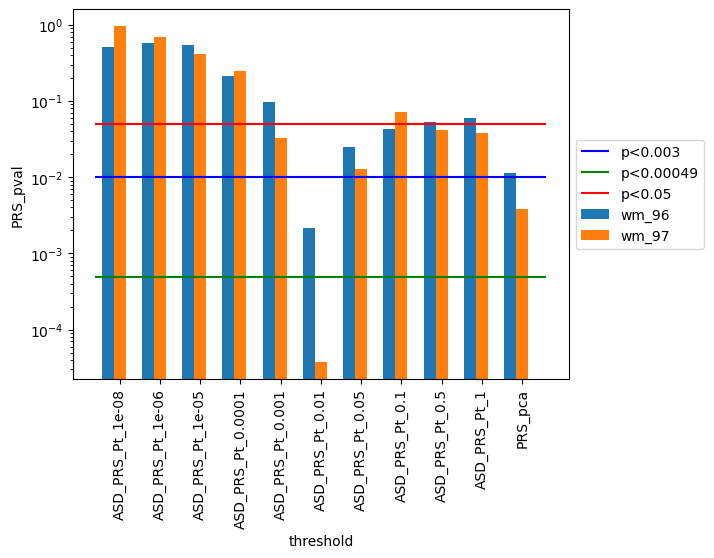

In [25]:
fig,ax = plt.subplots(1,1)
visualisation.SimplePlots.Bar(x='threshold',hue='Connection',y='PRS_pval',data=test[test['Connection'].isin(['wm_97','wm_96'])],
                             order={'x':[i for i in tract_volumes.columns if 'ASD_PRS' in i]+['PRS_pca']},
                             yscalelog=True,rotation_x=90,hline=[0.01,0.00049,0.05],
                              ax=ax,hline_label=['p<0.003','p<0.00049','p<0.05'],barwidth=0.6)
# ax.legend(['p<0.003','p<0.00049','SCR.L','SCL.R','PLIC.L','PLIC.R'],bbox_to_anchor=(1, 0.5))

In [49]:
stats.MultipleCorrection.matSpDLite(np.corrcoef(tract_volumes[[f'wm_{i}' for i in range(94,148)]],rowvar=False))

Effective Number of Independent Variables [Veff] is 49.96734600093054
Effective Number of Independent Variables [VeffLi] (Using equation 5 of Li and Ji 2005) is 30.0
The adjusted multiple testing correction p-val is alpha/lower(Meff) = 0.0016666666666666663


30.000000000000007

In [50]:
0.05/30/6

0.0002777777777777778

In [31]:
stats.MultipleCorrection.matSpDLite(np.corrcoef(tract_volumes[[i for i in tract_volumes.columns if 'ASD_PRS' in i]],rowvar=False))

Effective Number of Independent Variables [Veff] is 8.267278857828163
Effective Number of Independent Variables [VeffLi] (Using equation 5 of Li and Ji 2005) is 6.0
The adjusted multiple testing correction p-val is alpha/lower(Meff) = 0.008333333333333333


6.0

In [33]:
0.05/17/6

0.0004901960784313725

In [165]:
0.05/17/6

0.0004901960784313725

In [36]:
0.05/17

0.0029411764705882353

In [37]:
test.sort_values(by='PRS_pval').groupby('Connection').head(1)

,Connection,Intercept_coef,Intercept_pval,C(sex)[T.male]_coef,C(sex)[T.male]_pval,standardize(GA)_coef,standardize(GA)_pval,standardize(PMA)_coef,standardize(PMA)_pval,standardize(TBV)_coef,standardize(TBV)_pval,standardize(Q('euro_Anc_PC1'))_coef,standardize(Q('euro_Anc_PC1'))_pval,standardize(Q('euro_Anc_PC2'))_coef,standardize(Q('euro_Anc_PC2'))_pval,standardize(Q('euro_Anc_PC3'))_coef,standardize(Q('euro_Anc_PC3'))_pval,PRS_coef,PRS_pval,threshold
273,wm_97,0.044193,0.335780,-0.087987,0.202956,0.028264,0.487465,0.144202,1.769100e-02,0.782200,5.513256e-35,0.022153,0.475054,0.017387,0.573242,-0.000770,0.980100,0.129722,0.000037,ASD_PRS_Pt_0.01
278,wm_102,0.018700,0.652683,-0.037232,0.551402,0.047022,0.202818,-0.114719,3.693872e-02,0.987881,3.139969e-53,0.013066,0.641735,-0.003969,0.887087,0.015010,0.591692,0.098454,0.000511,ASD_PRS_Pt_0.01
279,wm_103,-0.031709,0.427805,0.063133,0.294114,0.039950,0.260428,-0.081510,1.223977e-01,0.962496,4.988856e-54,-0.004816,0.858474,0.011958,0.656536,-0.008684,0.746923,0.090019,0.000941,ASD_PRS_Pt_0.01
272,wm_96,0.050065,0.316441,-0.099678,0.185165,-0.030900,0.485517,0.221565,8.777193e-04,0.715523,1.987526e-27,0.028209,0.403434,-0.016522,0.622834,-0.052994,0.115949,0.104035,0.002171,ASD_PRS_Pt_0.01
317,wm_141,0.076138,0.240049,-0.151590,0.120326,0.057818,0.314319,0.176818,3.891888e-02,0.629633,2.788790e-15,0.041812,0.339489,0.064768,0.137802,0.041195,0.344902,0.133663,0.002370,ASD_PRS_Pt_0.01
181,wm_113,-0.042942,0.514514,0.085497,0.389272,-0.038385,0.505037,-0.065885,4.413467e-01,0.823221,9.816540e-23,-0.018485,0.675863,0.100411,0.024056,-0.051327,0.245487,-0.125216,0.004526,ASD_PRS_Pt_0.0001
264,wm_142,0.093747,0.109229,-0.186650,0.034718,0.081678,0.110771,0.124608,1.015605e-01,0.715804,5.651964e-22,0.038710,0.323897,0.063213,0.107553,0.144855,0.000266,0.106411,0.006436,ASD_PRS_Pt_0.001
300,wm_124,-0.015304,0.773558,0.030470,0.703303,0.038746,0.411865,0.095335,1.743472e-01,0.760146,2.596962e-27,0.038580,0.283776,-0.013997,0.695730,-0.068741,0.055991,0.097575,0.006822,ASD_PRS_Pt_0.01
129,wm_115,-0.109773,0.147844,0.218557,0.057068,0.039841,0.545332,-0.296477,2.747180e-03,0.814671,3.380893e-18,0.009437,0.852791,0.029644,0.558408,-0.032474,0.520396,-0.137469,0.006926,ASD_PRS_Pt_1e-05
189,wm_121,-0.083002,0.081632,0.165256,0.021750,0.057100,0.169952,-0.100437,1.045425e-01,0.924035,4.160331e-42,-0.014637,0.646271,0.029062,0.362875,-0.008618,0.786581,-0.076876,0.015408,ASD_PRS_Pt_0.0001


In [71]:
_, mass_univariate = stats.MassUnivariate.mass_univariate(
    tract_volumes,
    cat_independentVar_cols=['sex'],
    cont_independentVar_cols=['ASD_PRS_Pt_0.01','GA','PMA','TBV']+ancestry,
    dependentVar_cols=[f'wm_{i}' for i in range(94,148)])

In [73]:
to_plot_values = {int(k.replace('wm_','')):1-v for k,v in zip(mass_univariate.index.tolist(),mass_univariate["standardize(Q('ASD_PRS_Pt_0.01'))_pval"].values)}

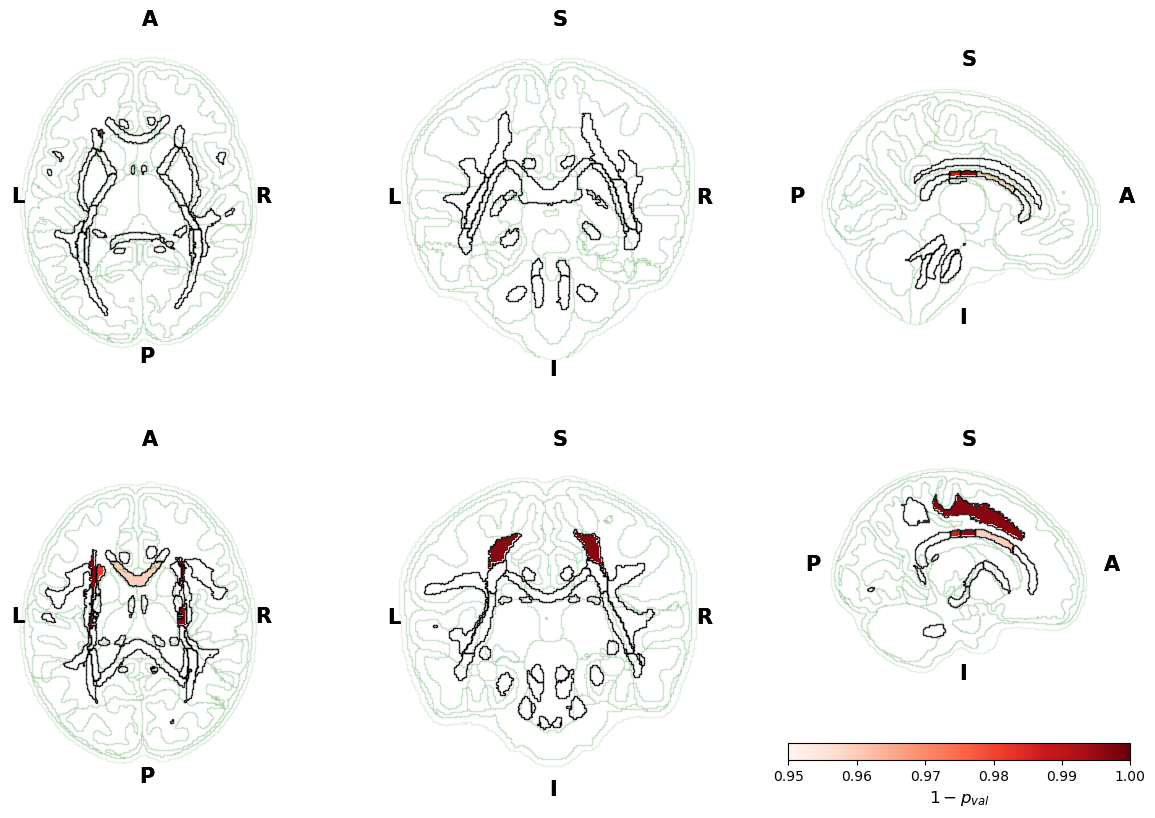

In [74]:
fig,axes=plt.subplots(2,3,figsize=(15,10))
axes = axes.flatten()
_,_ = visualisation.Brainmap.plot_segmentation(
    atlas_file='../dataset/visualise/wm_parcellation/parcellation_maps_05mm/reference-05mm-dHCP-structure-parcellation.nii.gz',
    regions_to_hide=[i for i in range(88)],
    outline_alpha=0.1,
    outline_colour='green',
    axes=axes[0:3])
_,_ = visualisation.Brainmap.plot_segmentation(
    atlas_file='../dataset/visualise/wm_parcellation/parcellation_maps_05mm/reference-05mm-WM-parcellation.nii.gz',
    plot_values=to_plot_values,
    plot_values_threshold=0.95,
    cb_title='$1-p_{val}$',
    cb_orientation='horizontal',
    cmap='Reds',
    axes=axes[0:3],fig=fig,colorbar=False,cb_vmin=0.95,cb_vmax=1)

atlas_slice = 120
_,_ = visualisation.Brainmap.plot_segmentation(
    atlas_file='../dataset/visualise/wm_parcellation/parcellation_maps_05mm/reference-05mm-dHCP-structure-parcellation.nii.gz',
    regions_to_hide=[i for i in range(88)],
    atlas_slice=atlas_slice,
    outline_alpha=0.1,
    outline_colour='green',
    axes=axes[3:6])
_,_ = visualisation.Brainmap.plot_segmentation(
    atlas_file='../dataset/visualise/wm_parcellation/parcellation_maps_05mm/reference-05mm-WM-parcellation.nii.gz',
    plot_values=to_plot_values,
    atlas_slice=atlas_slice,
    plot_values_threshold=0.95,
    cb_title='$1-p_{val}$',
    cb_orientation='horizontal',
    cmap='Reds',
    axes=axes[3:6],fig=fig,colorbar=True,cb_vmin=0.95,cb_vmax=1)

plt.savefig('wm_volume_asd_log_jacobians.png')

In [22]:
test = visualisation.Brainmap.get_ROIs_coordinates('../codes/FBA/output_ASD/5TT/structual_warped_wm_fod.nii.gz')

In [25]:
test[test['Label']==42.0]

,Label,X_vox,Y_vox,Z_vox,X_sca,Y_sca,Z_sca
41,42.0,43.847686,44.773286,38.077914,10.120741,-17.725989,13.893472


In [178]:
mass_univariate.sort_values(by="standardize(Q('PRS_pca'))_pval")

,Intercept_coef,Intercept_pval,C(sex)[T.male]_coef,C(sex)[T.male]_pval,standardize(Q('PRS_pca'))_coef,standardize(Q('PRS_pca'))_pval,standardize(GA)_coef,standardize(GA)_pval,standardize(PMA)_coef,standardize(PMA)_pval,standardize(TBV)_coef,standardize(TBV)_pval,standardize(Q('euro_Anc_PC1'))_coef,standardize(Q('euro_Anc_PC1'))_pval,standardize(Q('euro_Anc_PC2'))_coef,standardize(Q('euro_Anc_PC2'))_pval,standardize(Q('euro_Anc_PC3'))_coef,standardize(Q('euro_Anc_PC3'))_pval
wm_97,514.971739,4.540409e-225,-5.476390,0.248678,6.180222,0.003719,0.719653,0.794991,11.095355,7.627365e-03,51.668902,2.431680e-33,1.377922,0.518810,0.856597,0.687855,0.212076,0.920354
wm_102,2990.656637,3.326513e-241,-12.272448,0.594949,28.720491,0.005575,12.658094,0.348295,-36.859023,6.741674e-02,357.334929,3.292937e-52,4.677250,0.652729,-3.106121,0.764722,6.354791,0.538438
wm_96,472.199382,5.775485e-218,-5.999446,0.202456,5.426810,0.010006,-2.708034,0.324413,14.640575,4.162049e-04,43.838074,9.155608e-27,1.766329,0.404196,-1.354128,0.521779,-3.157281,0.134159
wm_141,182.642221,1.798159e-197,-3.426178,0.133269,2.596165,0.010964,0.965060,0.468299,4.525810,2.309988e-02,14.317890,1.013532e-14,0.976531,0.341266,1.349535,0.188261,1.024408,0.315071
wm_103,2900.214531,5.175433e-240,25.469268,0.261947,21.904846,0.030813,10.129125,0.444760,-24.667302,2.118726e-01,353.723903,1.133273e-52,-2.428059,0.812035,3.435922,0.736146,-2.098087,0.836156
wm_124,355.616247,1.276162e-224,1.420580,0.665896,2.997320,0.041571,1.060971,0.581048,4.488447,1.178169e-01,30.589678,1.237681e-26,1.543364,0.298098,-0.734582,0.619587,-2.697977,0.067879
wm_145,372.955249,1.386150e-208,0.283918,0.944964,3.570056,0.052132,1.225678,0.610124,-2.674534,4.550625e-01,41.747042,3.458829e-30,0.942102,0.611124,0.596497,0.747109,-2.135404,0.246675
wm_142,210.665590,1.010136e-209,-4.399509,0.056220,1.864825,0.068838,2.102637,0.117819,3.123136,1.187055e-01,18.375947,2.378668e-21,1.116779,0.280437,1.547073,0.134806,3.534675,0.000683
wm_140,207.995444,1.134990e-196,-1.029218,0.693933,1.971656,0.091265,-1.379815,0.366927,-1.510171,5.070099e-01,21.884180,8.364463e-23,0.045720,0.969032,-1.013367,0.389264,-1.530833,0.191673
wm_105,1084.141375,2.213837e-195,21.643072,0.118525,-10.169870,0.099386,10.790759,0.182510,-49.331021,5.736354e-05,131.759556,1.356719e-27,-5.017256,0.420701,8.291419,0.183263,-1.028580,0.867952


In [20]:
tract_volumes['wm_97_103'] = tract_volumes['wm_97'] + tract_volumes['wm_103']
tract_volumes['wm_96_102'] = tract_volumes['wm_96'] + tract_volumes['wm_102']

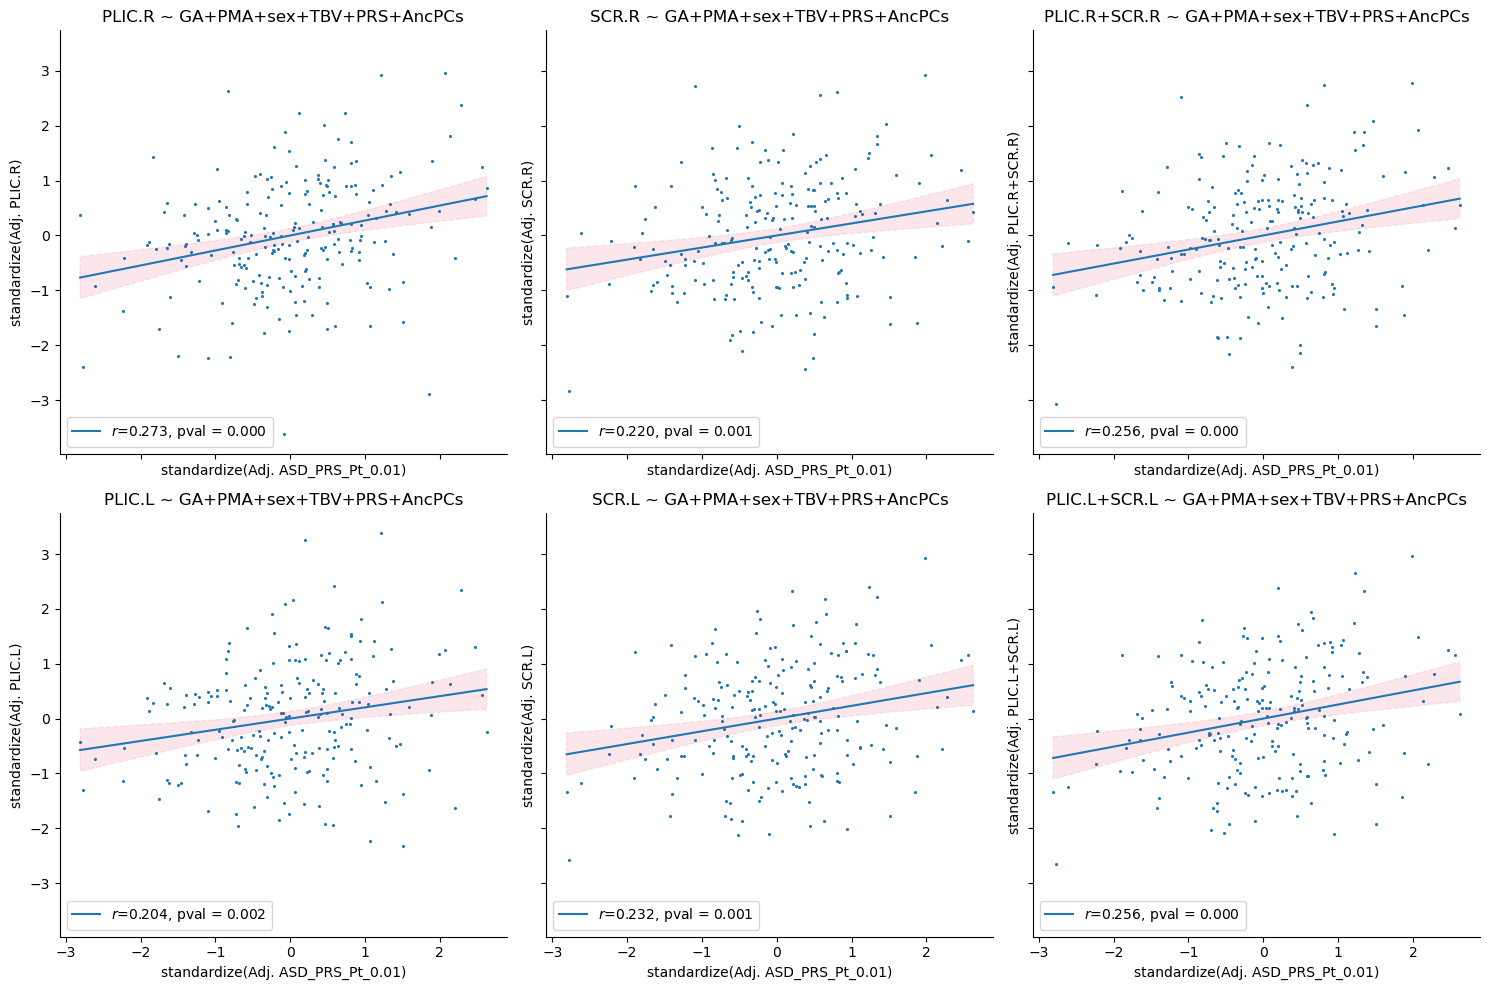

In [37]:
fig,axes=plt.subplots(2,3,sharex=True,sharey=True,figsize=(15,10))
axes=axes.flatten()
visualisation.SimplePlots.Scatter(y='wm_97',x='ASD_PRS_Pt_0.01',
                                  data=tract_volumes,adjust_covar={'y':['GA','PMA','sex','TBV'],'x':ancestry},
                                  title='PLIC.R ~ GA+PMA+sex+TBV+PRS+AncPCs',
                                  ylabel='PLIC.R',legend_loc='lower left',ax=axes[0])
visualisation.SimplePlots.Scatter(y='wm_103',x='ASD_PRS_Pt_0.01',
                                  data=tract_volumes,adjust_covar={'y':['GA','PMA','sex','TBV'],'x':ancestry},
                                  title='SCR.R ~ GA+PMA+sex+TBV+PRS+AncPCs',
                                  ylabel='SCR.R',legend_loc='lower left',ax=axes[1])
visualisation.SimplePlots.Scatter(y='wm_97_103',x='ASD_PRS_Pt_0.01',
                                  data=tract_volumes,adjust_covar={'y':['GA','PMA','sex','TBV'],'x':ancestry},
                                  title='PLIC.R+SCR.R ~ GA+PMA+sex+TBV+PRS+AncPCs',
                                  ylabel='PLIC.R+SCR.R',legend_loc='lower left',ax=axes[2])

visualisation.SimplePlots.Scatter(y='wm_96',x='ASD_PRS_Pt_0.01',
                                  data=tract_volumes,adjust_covar={'y':['GA','PMA','sex','TBV'],'x':ancestry},
                                  title='PLIC.L ~ GA+PMA+sex+TBV+PRS+AncPCs',
                                  ylabel='PLIC.L',legend_loc='lower left',ax=axes[3])
visualisation.SimplePlots.Scatter(y='wm_102',x='ASD_PRS_Pt_0.01',
                                  data=tract_volumes,adjust_covar={'y':['GA','PMA','sex','TBV'],'x':ancestry},
                                  title='SCR.L ~ GA+PMA+sex+TBV+PRS+AncPCs',
                                  ylabel='SCR.L',legend_loc='lower left',ax=axes[4])
visualisation.SimplePlots.Scatter(y='wm_96_102',x='ASD_PRS_Pt_0.01',
                                  data=tract_volumes,adjust_covar={'y':['GA','PMA','sex','TBV'],'x':ancestry},
                                  title='PLIC.L+SCR.L ~ GA+PMA+sex+TBV+PRS+AncPCs',
                                  ylabel='PLIC.L+SCR.L',legend_loc='lower left',ax=axes[5])


sns.despine()
plt.tight_layout()
plt.savefig('asd/wm_volume_ASD_regression.png',dpi=300)

In [60]:
to_bar_plot = test[test['Connection'].isin(['wm_97','wm_103','wm_97_103'])].copy()

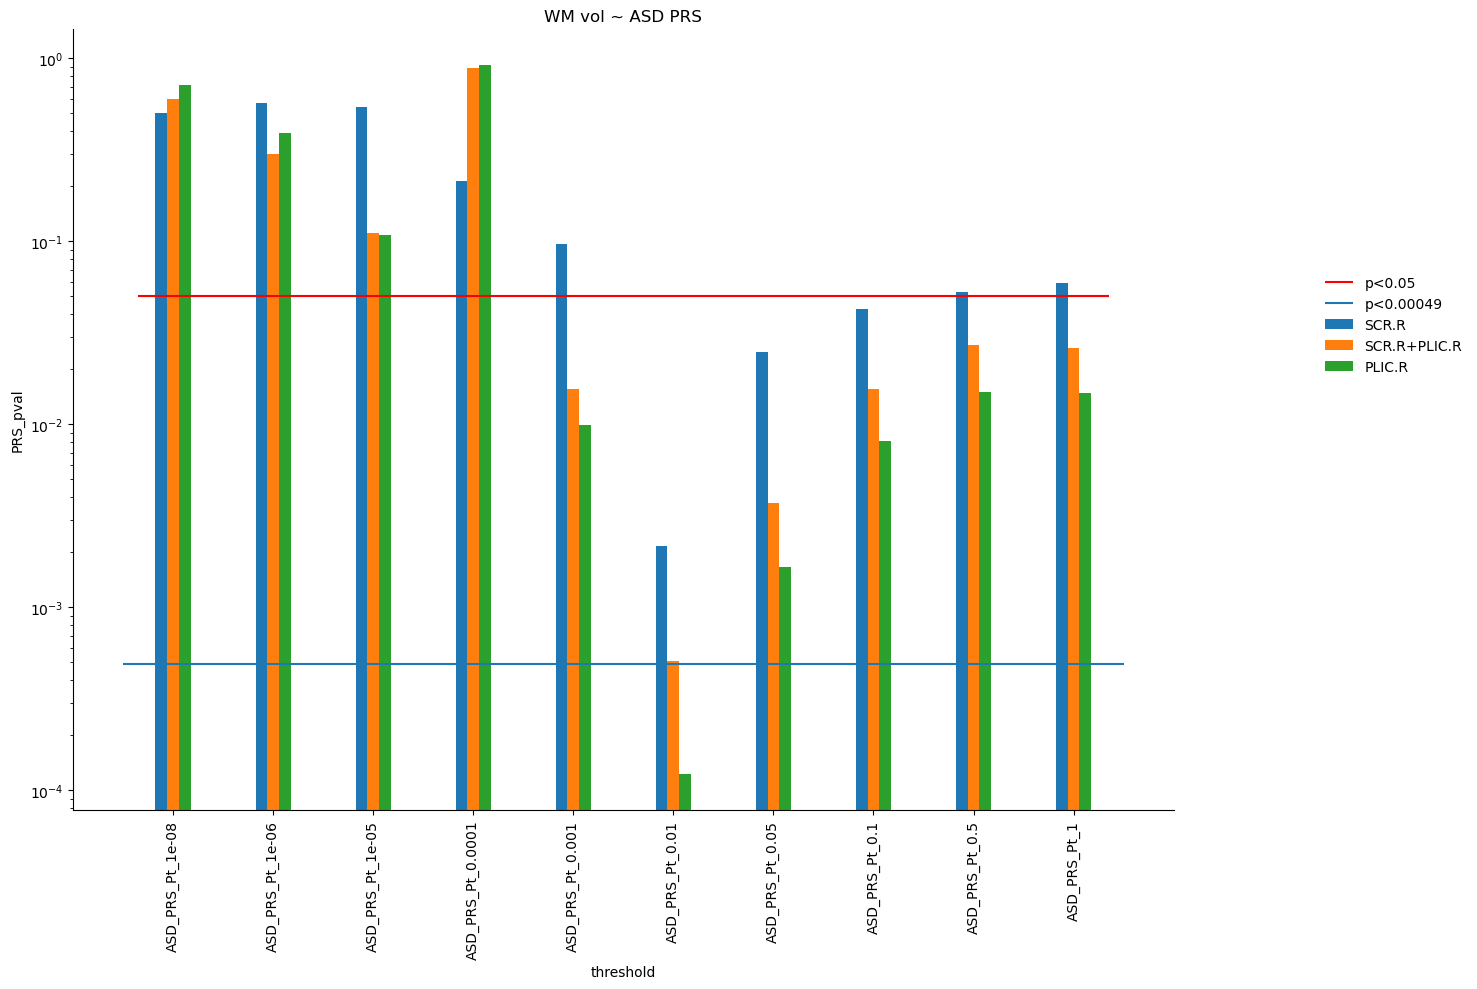

In [68]:
fig,ax = plt.subplots(1,1,figsize=(15,10))
visualisation.SimplePlots.Bar(x='threshold',
                              y='PRS_pval',
                              hue='Connection',
                              order={'x':[i for i in df.columns if 'ASD_PRS' in i]},
                              yscalelog=True,
                              hline=0.05,
                              hline_label='p<0.05',
                              rotation_x=90,
                              data=to_bar_plot,ax=ax)
ax.hlines(0.05/17/6,xmin=0.5,xmax=10.5,label='p<0.00049')
ax.legend(['p<0.05','p<0.00049','SCR.R','SCR.R+PLIC.R','PLIC.R'],loc='upper center',frameon=False,bbox_to_anchor=[1.2,0.7])
sns.despine()
ax.set_title('WM vol ~ ASD PRS')
plt.tight_layout()
# plt.savefig('wm_vol_regression_ASD_bar_1.png',dpi=300)

In [ ]:
fig,ax = plt.subplots(1,1)
visualisation.SimplePlots.Bar(x='threshold',
                              y='PRS_pval',
                              hue='Connection',
                              order={'x':[i for i in df.columns if 'ASD_PRS' in i]},
                              yscalelog=True,
                              hline=0.05,
                              hline_label='p<0.05',
                              rotation_x=90,
                              data=to_bar_plot,ax=ax)
ax.hlines(0.05/17/6,xmin=0.5,xmax=10.5,label='p<0.00049')
ax.legend(['p<0.05','p<0.00049','PLIC.L','SCR.L','SCR.L+PLIC.L'],loc='upper center',frameon=False,bbox_to_anchor=[1.2,0.7])
sns.despine()
ax.set_title('WM vol ~ ASD PRS')
plt.tight_layout()
plt.savefig('wm_vol_regression_ASD_bar_2.png',dpi=300)

In [42]:
test.sort_values(by=['PRS_pval'])

,Connection,Intercept_coef,Intercept_pval,C(sex)[T.male]_coef,C(sex)[T.male]_pval,standardize(GA)_coef,standardize(GA)_pval,standardize(PMA)_coef,standardize(PMA)_pval,standardize(TBV)_coef,standardize(TBV)_pval,standardize(Q('euro_Anc_PC1'))_coef,standardize(Q('euro_Anc_PC1'))_pval,standardize(Q('euro_Anc_PC2'))_coef,standardize(Q('euro_Anc_PC2'))_pval,standardize(Q('euro_Anc_PC3'))_coef,standardize(Q('euro_Anc_PC3'))_pval,PRS_coef,PRS_pval,threshold
283,wm_97,0.044193,0.335780,-0.087987,0.202956,0.028264,0.487465,0.144202,0.017691,0.782200,5.513256e-35,0.022153,0.475054,0.017387,0.573242,-0.000770,0.980100,0.129722,0.000037,ASD_PRS_Pt_0.01
334,wm_97_103,-0.020451,0.581124,0.040718,0.465262,0.038888,0.237521,-0.047786,0.327907,0.952739,3.382659e-58,-0.000692,0.977950,0.013036,0.601148,-0.007613,0.760290,0.097949,0.000112,ASD_PRS_Pt_0.01
335,wm_96_102,0.023789,0.538109,-0.047364,0.415206,0.036507,0.287256,-0.067332,0.186410,0.969874,1.141535e-56,0.015615,0.549852,-0.005925,0.819628,0.005241,0.840301,0.101525,0.000122,ASD_PRS_Pt_0.01
288,wm_102,0.018700,0.652683,-0.037232,0.551402,0.047022,0.202818,-0.114719,0.036939,0.987881,3.139969e-53,0.013066,0.641735,-0.003969,0.887087,0.015010,0.591692,0.098454,0.000511,ASD_PRS_Pt_0.01
289,wm_103,-0.031709,0.427805,0.063133,0.294114,0.039950,0.260428,-0.081510,0.122398,0.962496,4.988856e-54,-0.004816,0.858474,0.011958,0.656536,-0.008684,0.746923,0.090019,0.000941,ASD_PRS_Pt_0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,wm_115,-0.083398,0.275361,0.166044,0.148702,0.045672,0.496081,-0.308699,0.002213,0.828237,3.377125e-18,0.024051,0.642051,0.038834,0.453295,-0.026803,0.603530,0.000632,0.990118,ASD_PRS_Pt_0.1
112,wm_94,-0.006906,0.901205,0.013750,0.870113,-0.004700,0.922666,-0.180712,0.012739,0.958618,4.885576e-36,0.047832,0.201662,-0.031933,0.391411,-0.005077,0.891233,-0.000394,0.991523,ASD_PRS_Pt_1e-05
242,wm_112,-0.039057,0.552348,0.077763,0.432472,0.026204,0.648617,0.062083,0.467587,0.714910,2.570175e-18,-0.024177,0.583906,-0.022314,0.612891,-0.019833,0.652441,-0.000451,0.991750,ASD_PRS_Pt_0.001
302,wm_116,-0.007567,0.843076,0.015066,0.793280,0.075413,0.027010,-0.101462,0.044815,0.974457,1.212040e-57,0.009429,0.715135,-0.015197,0.554706,0.019133,0.457548,-0.000242,0.992494,ASD_PRS_Pt_0.01


In [187]:
test.sort_values(by='PRS_pval')

,Connection,Intercept_coef,Intercept_pval,C(sex)[T.male]_coef,C(sex)[T.male]_pval,standardize(GA)_coef,standardize(GA)_pval,standardize(PMA)_coef,standardize(PMA)_pval,standardize(TBV)_coef,standardize(TBV)_pval,standardize(Q('euro_Anc_PC1'))_coef,standardize(Q('euro_Anc_PC1'))_pval,standardize(Q('euro_Anc_PC2'))_coef,standardize(Q('euro_Anc_PC2'))_pval,standardize(Q('euro_Anc_PC3'))_coef,standardize(Q('euro_Anc_PC3'))_pval,PRS_coef,PRS_pval,threshold
181,wm_96,0.048057,0.273250,-0.095680,0.147382,-0.000141,0.997106,0.185372,0.001494,0.766868,3.035655e-36,0.025617,0.387250,0.001134,0.969317,-0.026415,0.370933,0.120000,0.000064,ASD_PRS_Pt_0.01
184,wm_102,-0.006807,0.856250,0.013553,0.810484,0.044052,0.187212,-0.099318,0.045733,0.988443,1.091448e-59,0.004106,0.871559,0.004117,0.870642,0.003106,0.902311,0.095492,0.000200,ASD_PRS_Pt_0.01
174,wm_141,0.092567,0.092551,-0.184300,0.026612,0.064840,0.177637,0.171999,0.016582,0.708503,9.758956e-24,0.038294,0.299193,0.067963,0.065900,0.108535,0.003464,0.117477,0.001423,ASD_PRS_Pt_0.001
204,wm_141,0.085855,0.118787,-0.170937,0.039344,0.079051,0.105501,0.149833,0.039115,0.712557,9.895499e-24,0.044415,0.231914,0.068054,0.066394,0.095643,0.010233,0.111006,0.002909,ASD_PRS_Pt_0.01
9,wm_112,-0.038256,0.509817,0.076168,0.382632,0.012735,0.803645,-0.026893,0.723671,0.843086,5.503428e-28,-0.031475,0.422852,0.045746,0.242931,-0.047183,0.229478,-0.109568,0.005250,ASD_PRS_Pt_1e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,wm_108,0.050282,0.308958,-0.100111,0.178006,0.115266,0.008705,-0.115431,0.075552,0.948115,5.831448e-41,-0.038087,0.254729,0.053659,0.107967,-0.006035,0.856401,-0.000707,0.982947,ASD_PRS_Pt_1e-08
96,wm_106,-0.015718,0.731058,0.031294,0.650765,0.063227,0.113132,-0.121578,0.040964,0.960863,1.519610e-46,0.024337,0.428730,0.020604,0.500923,-0.007347,0.809743,-0.000527,0.986209,ASD_PRS_Pt_1e-05
77,wm_128,-0.002425,0.962501,0.004829,0.950364,-0.005229,0.908044,-0.135805,0.044257,0.963177,8.891849e-40,0.013664,0.694168,0.006976,0.840625,0.029962,0.389597,0.000559,0.986960,ASD_PRS_Pt_1e-06
52,wm_138,0.108240,0.080124,-0.215505,0.020728,0.056756,0.294348,0.140446,0.083261,0.684790,9.568150e-19,0.022197,0.594310,-0.031020,0.454987,-0.033662,0.418881,0.000660,0.987184,ASD_PRS_Pt_1e-07


In [12]:
fd_mean_L = pd.read_csv('../codes/FBA/output_ASD/tractography/individual_tracts/plic_L/mean-fd-plic_L.txt',header=None)
log_fc_mean_L = pd.read_csv('../codes/FBA/output_ASD/tractography/individual_tracts/plic_L/mean-log_fc-plic_L.txt',header=None)
fdc_mean_L = pd.read_csv('../codes/FBA/output_ASD/tractography/individual_tracts/plic_L/mean-fdc-plic_L.txt',header=None)

fd_mean_R = pd.read_csv('../codes/FBA/output_ASD/tractography/individual_tracts/plic_R/mean-fd-plic_R.txt',header=None)
log_fc_mean_R = pd.read_csv('../codes/FBA/output_ASD/tractography/individual_tracts/plic_R/mean-log_fc-plic_R.txt',header=None)
fdc_mean_R = pd.read_csv('../codes/FBA/output_ASD/tractography/individual_tracts/plic_R/mean-fdc-plic_R.txt',header=None)

fd_mean_L_R = pd.read_csv('../codes/FBA/output_ASD/tractography/individual_tracts/plic_L_R/mean-fd-plic_L_R.txt',header=None)
log_fc_mean_L_R = pd.read_csv('../codes/FBA/output_ASD/tractography/individual_tracts/plic_L_R/mean-log_fc-plic_L_R.txt',header=None)
fdc_mean_L_R = pd.read_csv('../codes/FBA/output_ASD/tractography/individual_tracts/plic_L_R/mean-fdc-plic_L_R.txt',header=None)

In [13]:
mean_fixel = pd.concat([fd_mean_L,log_fc_mean_L,fdc_mean_L,
                        fd_mean_R,log_fc_mean_R,fdc_mean_R,
                        fd_mean_L_R,log_fc_mean_L_R,fdc_mean_L_R],axis=1)
mean_fixel.columns = ['FD_mean_L','log_FC_mean_L','FDC_mean_L',
                     'FD_mean_R','log_FC_mean_R','FDC_mean_R',
                     'FD_mean_L_R','log_FC_mean_L_R','FDC_mean_L_R']
tract_volumes = pd.concat([tract_volumes,mean_fixel],axis=1)

In [14]:
test = stats.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
    tract_volumes,
    thresholds=[i for i in tract_volumes.columns if 'ASD_PRS' in i]+['PRS_pca'],
    cat_independentVar_cols=['sex'],
    cont_independentVar_cols=['GA','PMA','TBV']+ancestry,
    dependentVar_cols=[i for i in tract_volumes.columns if '_mean' in i])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.93it/s]


In [15]:
to_plot = test[['Connection','PRS_pval','threshold']].copy()

In [16]:
to_plot['type'] = to_plot['Connection'].apply(lambda x: x.split('_mean')[0])

In [17]:
to_plot['Tract'] = to_plot['Connection'].apply(lambda x: '+'.join(x.split('_mean')[1].split('_')[1:]))

In [18]:
# visualisation.SimplePlots.Bar(x='threshold',y='PRS_pval',hue='Connection',data=to_plot[to_plot['type']=='log_FC'],
#                               order={'x':[i for i in tract_volumes.columns if 'ASD_PRS' in i]},
#                               yscalelog=True,hline=0.05,rotation_x=90)

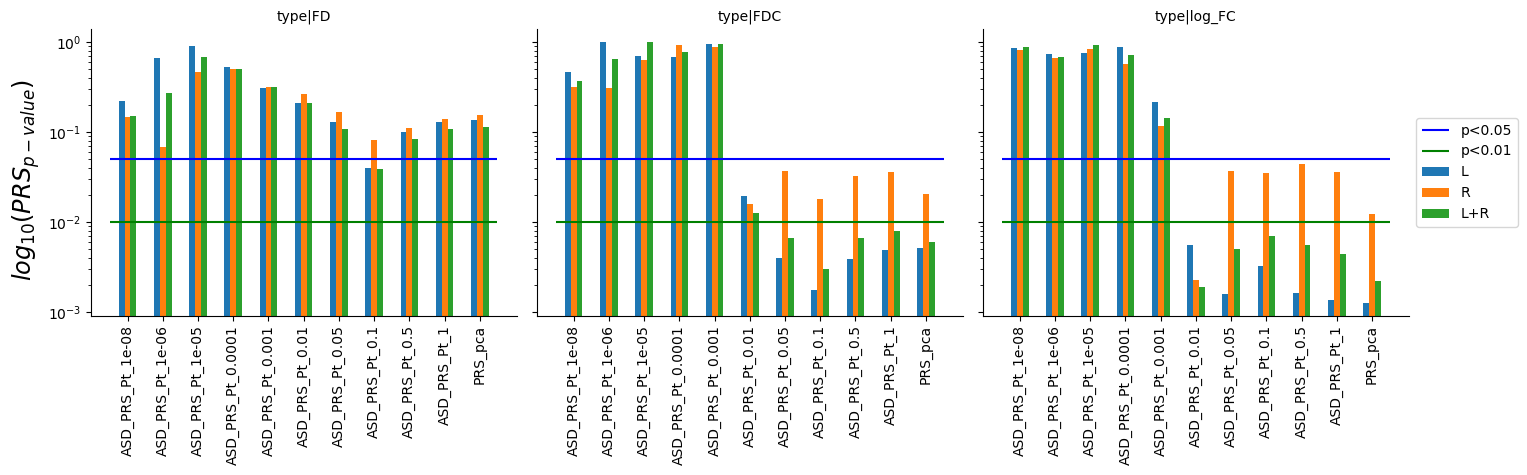

In [19]:
visualisation.SimplePlots.Bar(x='threshold',y='PRS_pval',hue='Tract',data=to_plot,
                              separateby='type',
                             order={'x':[i for i in tract_volumes.columns if 'ASD_PRS' in i]+['PRS_pca'],
                                   'hue':['L','R','L+R']},yscalelog=True,
                             ylabel='$log_{10}(PRS_{p-value})$',rotation_x=90,hline=[0.05,0.01],hline_label=['p<0.05','p<0.01'],
                             figsize=(15,5),barwidth=0.5,xlabel=None,ylabel_pos=(-.015,.6))
plt.tight_layout()
sns.despine()

<AxesSubplot:xlabel='standardize(Adj. ASD_PRS_Pt_0.01)', ylabel='standardize(Adj. log_FC_mean)'>

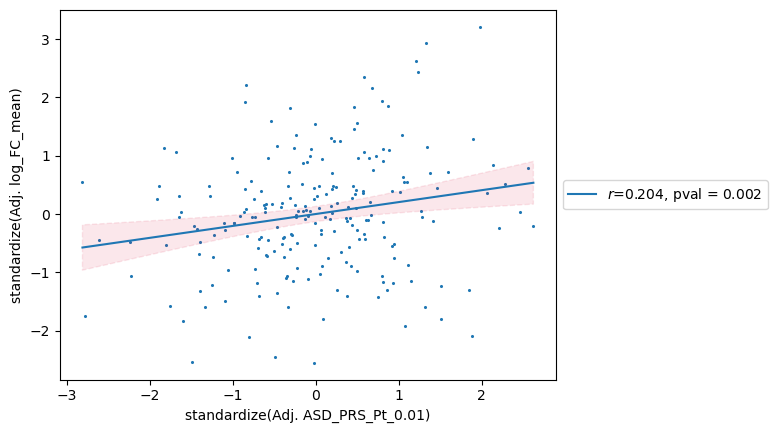

In [55]:
visualisation.SimplePlots.Scatter(x='ASD_PRS_Pt_0.01',y='log_FC_mean',data=tract_volumes,adjust_covar={'x':ancestry,
                                                                                                      'y':['sex','GA','PMA','TBV']})

In [22]:
[i for i in tract_volumes.columns if '_mean' in i]

[]

In [19]:
_,mass_univariate = stats.MassUnivariate.mass_univariate(
    tract_volumes,
    cat_independentVar_cols=['sex'],
    cont_independentVar_cols=['ASD_PRS_Pt_0.01','GA','PMA','TBV']+ancestry,
    dependentVar_cols=[i for i in tract_volumes.columns if '_mean' in i])

UnboundLocalError: local variable 'last_model' referenced before assignment

In [17]:
mass_univariate

,Intercept_coef,Intercept_pval,C(sex)[T.male]_coef,C(sex)[T.male]_pval,standardize(Q('ASD_PRS_Pt_0.01'))_coef,standardize(Q('ASD_PRS_Pt_0.01'))_pval,standardize(GA)_coef,standardize(GA)_pval,standardize(PMA)_coef,standardize(PMA)_pval,standardize(TBV)_coef,standardize(TBV)_pval,standardize(Q('euro_Anc_PC1'))_coef,standardize(Q('euro_Anc_PC1'))_pval,standardize(Q('euro_Anc_PC2'))_coef,standardize(Q('euro_Anc_PC2'))_pval,standardize(Q('euro_Anc_PC3'))_coef,standardize(Q('euro_Anc_PC3'))_pval
FD_mean_L,0.521520,4.661015e-226,-0.008795,0.065095,0.002680,0.207551,0.008322,0.003274,0.009804,1.914603e-02,0.003238,3.696747e-01,0.001608,0.451374,6.533820e-08,0.999975,-0.000890,0.675608
log_FC_mean_L,0.051102,1.035423e-17,-0.019766,0.016684,0.010237,0.005657,0.010634,0.028841,0.033709,4.685450e-06,0.052367,5.771716e-15,0.000740,0.840955,-2.215420e-03,0.546155,0.000411,0.910880
FDC_mean_L,0.552939,9.811313e-190,-0.019372,0.010430,0.007898,0.019336,0.012735,0.004380,0.031009,4.192495e-06,0.028838,8.844417e-07,0.002276,0.499944,-2.082747e-03,0.535214,-0.001351,0.687693
FD_mean_R,0.528164,1.060286e-231,-0.012538,0.005990,0.002258,0.264531,0.008872,0.001022,0.009763,1.433691e-02,0.002092,5.426164e-01,0.001488,0.464382,-4.300556e-04,0.831633,0.000206,0.918863
log_FC_mean_R,0.050477,1.238076e-18,-0.012634,0.108106,0.010802,0.002296,0.008877,0.055903,0.038901,4.521876e-08,0.051919,7.578678e-16,0.001250,0.722664,-2.174437e-03,0.535383,0.000423,0.904054
FDC_mean_R,0.560174,4.528130e-196,-0.019360,0.006788,0.007698,0.015854,0.012323,0.003531,0.033541,1.696426e-07,0.028012,4.495075e-07,0.002754,0.387728,-2.155217e-03,0.497038,0.000081,0.979681
FD_mean_L_R,0.484258,3.118466e-234,-0.009513,0.019085,0.002259,0.211038,0.007486,0.001861,0.009172,9.948106e-03,0.002796,3.617327e-01,0.001506,0.406408,-2.946013e-04,0.870275,-0.000317,0.860728
log_FC_mean_L_R,0.051139,1.051791e-20,-0.015645,0.035719,0.010406,0.001901,0.009603,0.028919,0.034196,3.245736e-07,0.053207,5.920683e-18,0.000884,0.790722,-2.221656e-03,0.503006,0.000223,0.946478
FDC_mean_L_R,0.513398,4.432352e-198,-0.017446,0.006507,0.007141,0.012586,0.011077,0.003443,0.028972,4.406072e-07,0.027109,5.878052e-08,0.002284,0.424248,-2.085883e-03,0.463443,-0.000670,0.813926


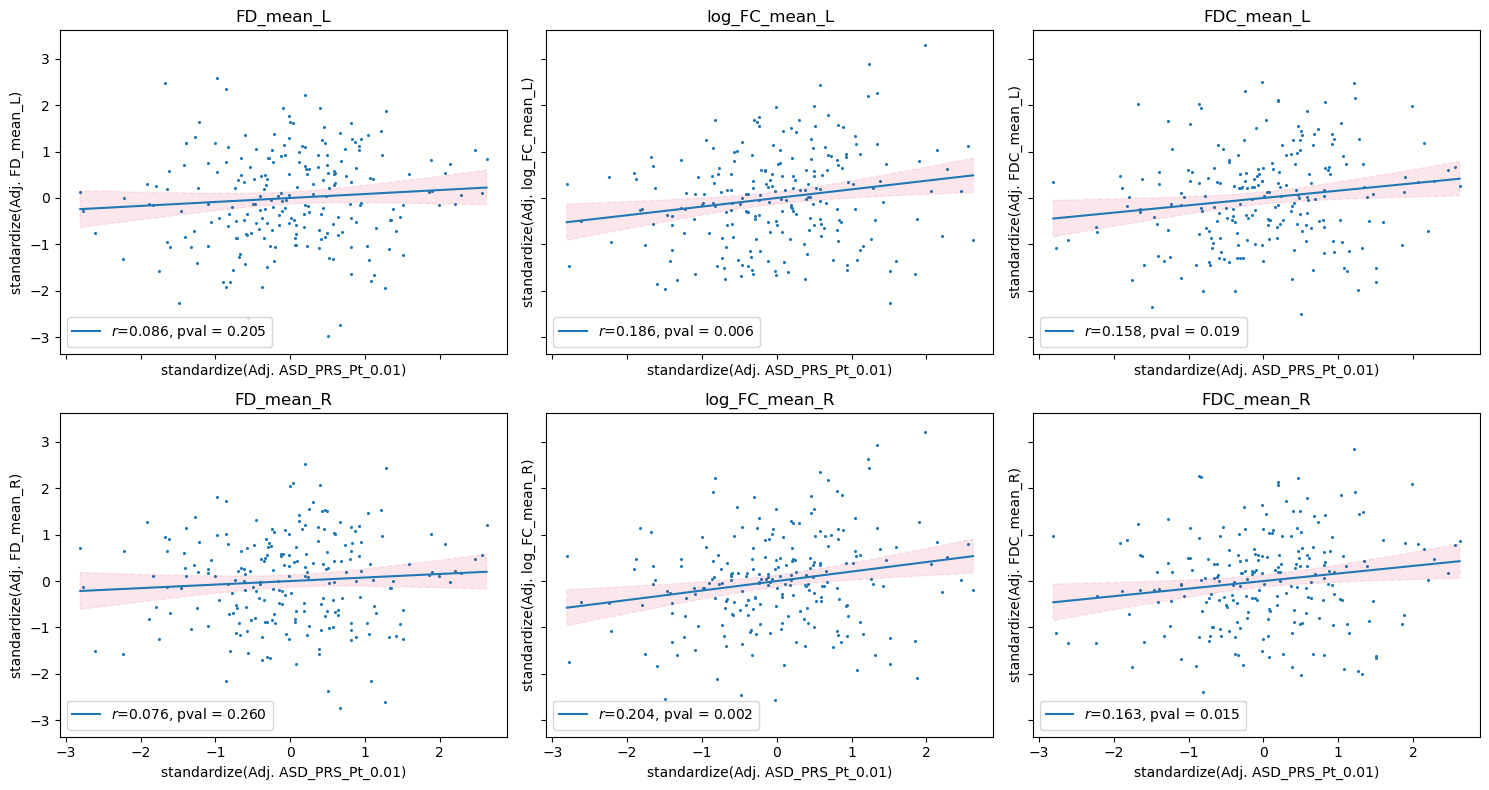

In [122]:
fig,axes=plt.subplots(2,3,sharey=True,sharex=True,figsize=(15,8))
axes = axes.flatten()
for ax,val in zip(axes,['FD_mean_L','log_FC_mean_L','FDC_mean_L',
                       'FD_mean_R','log_FC_mean_R','FDC_mean_R']):
    visualisation.SimplePlots.Scatter(x='ASD_PRS_Pt_0.01',
                                      y=val,
                                      adjust_covar={'x':ancestry,'y':['GA','PMA','TBV','sex']},
                                     data=tract_volumes,ax=ax,legend_loc='lower left',title=f'{val}')
plt.tight_layout()
plt.savefig('asd/mean_fba_together.png',dpi=300)

In [73]:
test.sort_values(by='PRS_pval')

,Connection,Intercept_coef,Intercept_pval,C(sex)[T.male]_coef,C(sex)[T.male]_pval,standardize(GA)_coef,standardize(GA)_pval,standardize(PMA)_coef,standardize(PMA)_pval,standardize(TBV)_coef,standardize(TBV)_pval,standardize(Q('euro_Anc_PC1'))_coef,standardize(Q('euro_Anc_PC1'))_pval,standardize(Q('euro_Anc_PC2'))_coef,standardize(Q('euro_Anc_PC2'))_pval,standardize(Q('euro_Anc_PC3'))_coef,standardize(Q('euro_Anc_PC3'))_pval,PRS_coef,PRS_pval,threshold
16,log_FC_mean,0.050477,1.238076e-18,-0.012634,0.108106,0.008877,0.055903,0.038901,4.521876e-08,0.051919,7.578678e-16,0.001250,0.722664,-0.002174,0.535383,0.000423,0.904054,0.010802,0.002296,ASD_PRS_Pt_0.01
17,FDC_mean,0.560174,4.528130e-196,-0.019360,0.006788,0.012323,0.003531,0.033541,1.696426e-07,0.028012,4.495075e-07,0.002754,0.387728,-0.002155,0.497038,0.000081,0.979681,0.007698,0.015854,ASD_PRS_Pt_0.01
23,FDC_mean,0.559584,4.634317e-196,-0.018184,0.010758,0.011246,0.007036,0.034837,4.701856e-08,0.027073,9.097050e-07,0.002816,0.377897,-0.002713,0.395790,-0.000080,0.979845,0.007489,0.018167,ASD_PRS_Pt_0.1
26,FDC_mean,0.559558,7.694659e-196,-0.018132,0.011170,0.011099,0.007915,0.034504,7.103731e-08,0.026923,1.088367e-06,0.002540,0.426186,-0.002800,0.383563,-0.000139,0.965391,0.006815,0.032525,ASD_PRS_Pt_0.5
22,log_FC_mean,0.049632,7.036007e-18,-0.010952,0.167083,0.007143,0.123450,0.041111,9.216355e-09,0.050373,5.589935e-15,0.001017,0.775521,-0.002596,0.467183,0.000509,0.886329,0.007442,0.035491,ASD_PRS_Pt_0.1
29,FDC_mean,0.559600,8.314434e-196,-0.018217,0.010839,0.011184,0.007511,0.034369,8.315877e-08,0.026997,1.037592e-06,0.002645,0.408221,-0.002735,0.394292,-0.000148,0.963002,0.006695,0.036196,ASD_PRS_Pt_1
28,log_FC_mean,0.049655,6.883571e-18,-0.010997,0.165375,0.007140,0.123663,0.040475,1.686701e-08,0.050355,5.718778e-15,0.000920,0.796169,-0.002726,0.446212,0.000342,0.923648,0.007453,0.036461,ASD_PRS_Pt_1
20,FDC_mean,0.560107,9.717038e-196,-0.019227,0.007380,0.011051,0.008201,0.035036,4.278905e-08,0.027181,9.026511e-07,0.002800,0.382583,-0.002344,0.462700,0.000600,0.850077,0.006603,0.036735,ASD_PRS_Pt_0.05
19,log_FC_mean,0.050219,3.732437e-18,-0.012119,0.127626,0.006991,0.131420,0.041220,8.414128e-09,0.050558,4.837234e-15,0.001091,0.760105,-0.002289,0.519895,0.001176,0.739902,0.007335,0.037399,ASD_PRS_Pt_0.05
25,log_FC_mean,0.049607,7.680881e-18,-0.010901,0.169397,0.007019,0.130187,0.040708,1.393659e-08,0.050246,6.592102e-15,0.000772,0.828462,-0.002736,0.445331,0.000405,0.909713,0.007155,0.044212,ASD_PRS_Pt_0.5


In [20]:
dHCP_outcomes = pd.read_csv(f'../dataset/participant_outcome/DHCPNDH1-LeHaiOutcome_DATA_LABELS_2022-06-09_0947.csv')
dHCP_outcomes_CBCL_Bayley = dHCP_outcomes.iloc[:,np.r_[0,4,11:13,13,16:19,21:24,34,56,77:92]].copy()
# dHCP_outcomes_CBCL_Bayley = dHCP_outcomes.iloc[:,np.r_[0,4,11:13,13,18,23,83:90]].copy()
# dHCP_outcomes_CBCL_Bayley = dHCP_outcomes.iloc[:,np.r_[0,4,11:13,83:90]].copy()
# dHCP_outcomes_CBCL_Bayley = dHCP_outcomes.iloc[:,np.r_[0,4,11:13,21, 22, 23, 24, 25, 29, 30]].copy()
dHCP_outcomes_CBCL_Bayley['Assessment Age'] = dHCP_outcomes_CBCL_Bayley['Corrected Age - Months'] + dHCP_outcomes_CBCL_Bayley['Corrected Age - Days']/30
dHCP_outcomes_CBCL_Bayley.rename(columns={'IMD Score':'IMD'},inplace=True)
dHCP_outcomes_CBCL_Bayley = dHCP_outcomes_CBCL_Bayley.dropna()
dHCP_total_QCHAT_SCORE = dHCP_outcomes.iloc[:,np.r_[0,72]]

In [29]:
test = pd.merge(dHCP_outcomes_CBCL_Bayley,tract_volumes,left_on='Participant ID',right_on='ID').copy()

In [47]:
mass_univariate = stats.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
    test,
    threshold_prefix='FBA',
    thresholds=[i for i in test.columns if 'mean' in i],
    cat_independentVar_cols=['sex'],
    cont_independentVar_cols=['Assessment Age','IMD','PMA'],
    dependentVar_cols=[i for i in test.columns if 'Scaled' in i])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.31it/s]


In [27]:
[i for i in test.columns if 'Motor Scaled' in i]

['Fine Motor Scaled Score',
 'Gross Motor Scaled Score',
 'Sum Motor Scaled Scores']

In [ ]:
test['']

In [48]:
mass_univariate.sort_values(by='FBA_pval')

,Connection,Intercept_coef,Intercept_pval,C(sex)[T.male]_coef,C(sex)[T.male]_pval,standardize(Q('Assessment Age'))_coef,standardize(Q('Assessment Age'))_pval,standardize(IMD)_coef,standardize(IMD)_pval,standardize(PMA)_coef,standardize(PMA)_pval,FBA_coef,FBA_pval,threshold
42,Cognitive Scaled Score,10.685531,3.467423e-115,-0.375139,0.170569,-0.400859,0.003602,-0.076360,0.571923,0.214763,0.179392,0.385196,0.016690,FD_mean_L_R
0,Cognitive Scaled Score,10.696106,2.323411e-115,-0.396522,0.146383,-0.409759,0.002960,-0.078203,0.562745,0.236599,0.129140,0.370876,0.017661,FD_mean_L
21,Cognitive Scaled Score,10.674418,1.075762e-114,-0.352670,0.201515,-0.391813,0.004518,-0.084204,0.533935,0.233532,0.143127,0.355831,0.026886,FD_mean_R
35,Cognitive Scaled Score,10.732151,2.250999e-115,-0.469404,0.086348,-0.372296,0.007338,-0.065170,0.632118,0.046462,0.840621,0.453514,0.049211,FDC_mean_R
56,Cognitive Scaled Score,10.736775,2.570016e-115,-0.478753,0.080790,-0.383918,0.005616,-0.063277,0.642604,0.070349,0.756979,0.428746,0.059049,FDC_mean_L_R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,Expressive Communication Scaled Score,9.873272,5.549677e-89,-0.589912,0.107849,0.030101,0.868107,-0.179925,0.318400,0.422737,0.164659,-0.026385,0.930248,log_FC_mean_L
53,Fine Motor Scaled Score,11.859814,4.561526e-111,-0.364898,0.260112,0.200527,0.208501,-0.013567,0.931644,0.026346,0.925657,-0.013946,0.960430,log_FC_mean_L_R
11,Fine Motor Scaled Score,11.860600,1.951220e-111,-0.366487,0.253392,0.200857,0.206987,-0.013175,0.933455,0.022295,0.933163,-0.009329,0.971823,log_FC_mean_L
50,Receptive Communication Scaled Score,11.551982,3.412989e-90,-1.050161,0.013687,-0.076674,0.712080,-0.116685,0.572234,0.326338,0.376565,0.006687,0.985463,log_FC_mean_L_R
